Erfan Seyed Salehi 93107127

Introduction to Machine Learning - Second Programming Assignment

The first step would be to import the required libraries and packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm

For the first part, we have to select one of the users and extract the notification data associated with him. We will select the user in the first row of "train.csv".

In [2]:
train = pd.read_csv('data/train/train.csv')
user_id = train.iloc[0,0]
user_notifs = train[train['user_id'] == user_id]
user_notifs = user_notifs['notif_id']
f = open("data/train/notifs.txt" , "r")
lines = f.readlines()
list_of_lists = []
for x in lines:
    list_of_lists.append(x.split(' '))
    
f.close()
for i in range(0,len(list_of_lists)):
    list_of_lists[i] = [int(j) for j in list_of_lists[i]]
notifs = pd.DataFrame(list_of_lists )
notifs = notifs.iloc[:,0:5]
notifs.columns = [ 'notif_id' , 'DOW_send' , 'H_send' , 'M_send' , 'Cat_feature' ]
user_notif_data = notifs.index.values[notifs['notif_id'].isin(user_notifs.tolist())]
user_notif_data = user_notif_data.tolist()
ls = [list_of_lists[i] for i in user_notif_data]
notif_data = []
for i in ls:
    notif_data.append(' '.join(str(j) for j in i))
notif_data = '\n'.join(notif_data)
f = open("search-result.txt", "w")
f.write(notif_data)
f.close()

For the next part, we plot the required graphs.

The first required graph is a scatter plot of 'N1' and 'N2' features for users.

Text(0,0.5,'N2 feature')

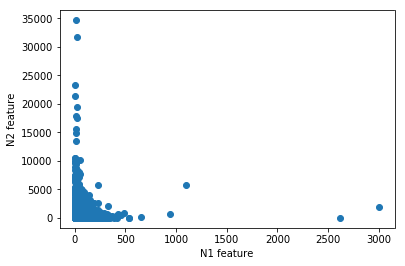

In [4]:
n1n2 = pd.read_csv('data/train/users.csv',usecols =[7, 8 ])
n1n2 = n1n2.dropna()
plt.scatter(n1n2['N1'],n1n2['N2'] )
plt.xlabel("N1 feature")
plt.ylabel("N2 feature")

The second graph

C:\Users\Erfan\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


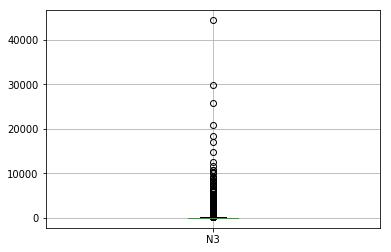

In [5]:
n3 = pd.read_csv('data/train/users.csv',usecols =[ 9 ])
n3 = n3.dropna()
n3.plot.box(grid='True')

We use the code below to plot a histogram for the collection of words in the notifications. We observe that words with lower indices in the dictionary, have higher abundance.

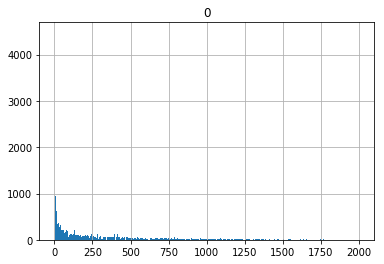

In [6]:
f = open("data/train/notifs.txt" , "r")
lines = f.readlines()
words_collection = []
list_of_lists = []
x = lines[0]
y = x.split(' ')
z = y[5:]
for x in lines:
    list_of_lists.append(x.split(' ')[5:])
for sublist in list_of_lists:
    for item in sublist:
        words_collection.append(item)
words_collection = [int(i) for i in words_collection]        
df = pd.DataFrame(words_collection)
hist = df.hist(bins = len(set(words_collection)))
f.close()

Due to the discrete nature of data, the bar plot of the data is essentially the same as its histogram. After plotting the histogram, we observe that there is plenty of notifications having delivery minute of exactly 30 minutes. besides that, delivery minute seems to be uniformly distributed across the domain.

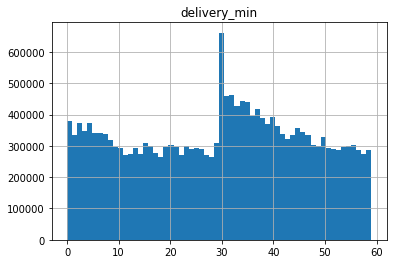

In [7]:
deliverymin = pd.read_csv('data/train/train.csv',usecols =[8])
hist = deliverymin.hist(bins=60)

We will plot a pie chart to show the distribution of the categorical feature for notifications. 

([<matplotlib.patches.Wedge at 0x1ff806d0470>,
 [Text(0.854861,0.692252,'0'),
  Text(0.214981,1.07879,'1'),
  Text(-0.208871,1.07999,'2'),
  Text(-0.920838,0.601712,'3'),
  Text(-1.09007,0.147436,'4'),
  Text(-1.07157,-0.248457,'5'),
  Text(0.310177,-1.05536,'7')])

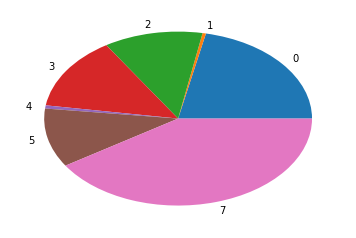

In [8]:
f = open("data/train/notifs.txt", "r")
lines = f.readlines()
notifs_feature = []
for x in lines:
    notifs_feature.append(x.split(' ')[4])
f.close()
notifs_feature = [ int(x) for x in notifs_feature ]
unique_features = set(notifs_feature)
uniq_count = []
for i in unique_features:
    uniq_count.append(notifs_feature.count(i))
plt.pie(uniq_count , labels = unique_features )

Let's start preparing the data. First, we will merge sparse.csv and user.csv to get all of the user features together. After dropping the NA entries, the size of the dataframe will be severely reduced. After that, we read all the notification data from notifs.txt and save them in a dataframe. 

Unfortunately, we cannot the word data in our model. Word data can be modelled as about 2000 dummy variables. Each variable will correspond to the existance of a word in the notification, Having only the values of 1 and 0. Including those variables will result in extremly large dataframes which cannot be saved in memory. 

The categorical feature for notifications will be converted to categorical data and then will be converted to 7 different dummy variables.

Also, we cannot include categorical features 'C1' through 'C6'. Due to the fact that each of these features have many categories, including them using dummy variables will be impossible. For similar reasons as before, the resulting dataframe will be too large. 

Time of sending the notification and time of delivery will be highly correlated. Therefore including only one is enough. Time of delivery is not available for test data. Therefore, we will only include time of sending the notification. Interaction time is data leakage and cannot be included in the model. 

We will merge all of the dataframes together to use them for training our model. We will also save the dataframe as a csv file to make this process faster for later stages.

In [9]:
sparse = pd.read_csv('data/train/sparse.csv')
user = pd.read_csv('data/train/users.csv')
user = pd.merge(user ,sparse, on="user_id")
user = user.dropna()
f = open("data/train/notifs.txt" , "r")
lines = f.readlines()
list_of_lists = []
for x in lines:
    list_of_lists.append(x.split(' '))
    
f.close()
for i in range(0,len(list_of_lists)):
    list_of_lists[i] = [int(j) for j in list_of_lists[i]]
notifs = pd.DataFrame(list_of_lists )


notifs = notifs.iloc[:,0:5]
notifs.columns = [ 'notif_id' , 'DOW_send' , 'H_send' , 'M_send' , 'Cat_feature' ]
train = pd.read_csv('data/train/train.csv')
train = pd.merge(train,notifs , on="notif_id")
train = pd.merge(train,user , on="user_id")
train = train.drop(['interaction_dow' , 'interaction_hour' , 'interaction_min' , 'delivery_min' , 'delivery_dow' , 'delivery_hour' , 'C1' , 'C2' , 'C3' , 'C4' , 'C5' , 'C6' ], axis=1)



train['Cat_feature'] = train['Cat_feature'].astype('category')
train = pd.get_dummies(train)
train.to_csv('data/train/merge.csv', encoding='utf-8' , index=False )

In [10]:
train = pd.read_csv('data/train/merge.csv')
Colnames = list(train)
Xcnames = Colnames[3:]
X = train[Xcnames]
y = train[Colnames[2]]

We can use statistical p tests to remove variables that are not quite important enough for our regression model. A threshold of 0.05 is used.

In [5]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())
table = result.summary2().tables[1]
features = table[table['P>|z|'] > 0.05].index.tolist()

X = train[features]

Optimization terminated successfully.
         Current function value: 0.199840
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.020       
Dependent Variable: interaction      AIC:              1542982.4052
Date:               2018-11-30 17:28 BIC:              1544417.5186
No. Observations:   3860001          Log-Likelihood:   -7.7138e+05 
Df Model:           108              LL-Null:          -7.8746e+05 
Df Residuals:       3859892          LLR p-value:      0.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     7.0000                                         
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
delivery_dow       0.0050   0.0011    4.4790 0.0000  0.0028  0.0072
delivery_hour      0.0027   0.0005    5.4

To alleviate the problem of unbalanced number of samples for the two different data classes. We will use the 'balanced' mode for class weight in logistic regression. To have an estimate of the true error of the model, we will use cross validation methods with test size of 30 percent. We go ahead and train the model. Due to the extreme memory usage in this problem, we have to constantly be careful to not run out of memory.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
del X,y
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train )

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [12]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.58


As we can see, the model doesn't perform very well on the test data that we created. This is due to the fact that we forced the model to train with balanced feature weights. However, if we don't do that the optimized model will be a regression model that outputs zero for almost every sample and that would be worthless. The confusion matrix for the model is as followed.

In [13]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[634076 464060]
 [ 24006  35859]]


The precision, recall, f1-score and the support statistics of the model on test data is printed.

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("Accuracy is " + str(confusion_matrix[1,1]/sum(sum(confusion_matrix))))
print("Specifity is " + str(confusion_matrix[1,0]/(confusion_matrix[1,0]+confusion_matrix[0,1])))

             precision    recall  f1-score   support

          0       0.96      0.58      0.72   1098136
          1       0.07      0.60      0.13     59865

avg / total       0.92      0.58      0.69   1158001

Accuracy is 0.030966294502336355
Specifity is 0.0491859707498576


The ROC curve and the AUC are plotted and printed below.

The Area under curve is 0.5882044608418947


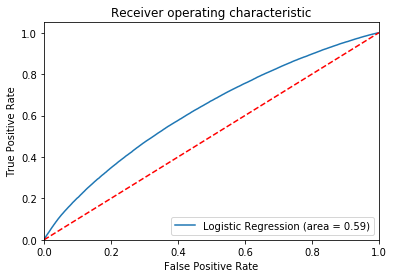

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
print("The Area under curve is "+ str(logit_roc_auc))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [16]:
dist = pow(fpr-1,2)+pow(tpr-1,2)
index_min = np.argmin(dist)
print(thresholds[index_min])

0.04270621336549445


In [20]:
sparse = pd.read_csv('data/train/sparse.csv')
user = pd.read_csv('data/test/users.csv')
user = pd.merge(user ,sparse, on="user_id")
user = user.dropna()
f = open("data/test/notifs.txt" , "r")
lines = f.readlines()
list_of_lists = []
for x in lines:
    list_of_lists.append(x.split(' '))
    
f.close()
for i in range(0,len(list_of_lists)):
    list_of_lists[i] = [int(j) for j in list_of_lists[i]]
notifs = pd.DataFrame(list_of_lists )


notifs = notifs.iloc[:,0:5]
notifs.columns = [ 'notif_id' , 'DOW_send' , 'H_send' , 'M_send' , 'Cat_feature' ]
test = pd.read_csv('data/test/test.csv')
test = pd.merge(test,notifs , on="notif_id")
test = pd.merge(test,user , on="user_id")
test = test.drop(['C1' , 'C2' , 'C3' , 'C4' , 'C5' , 'C6' ], axis=1)



test['Cat_feature'] = test['Cat_feature'].astype('category')
test = pd.get_dummies(test)
test.to_csv('data/test/merge.csv', encoding='utf-8' , index=False )

In [24]:
Colnames = list(test)
Xcnames = Colnames[2:]
X = test[Xcnames]

In [26]:
y_pred = logreg.predict(X)